In [1]:
import numpy as np
import copy
from typing import List, Tuple
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from matplotlib.ticker import MaxNLocator

from methods import generate_tester, select_parent_torneio, Individual

In [2]:
load_dotenv()

POP_SIZE = int(os.getenv("POP_SIZE", 10))
GEN = int(os.getenv("GEN", 1000))
MU_TAX_1 = float(os.getenv("MU_TAX", 0.05))

NUM_ISLAND = int(os.getenv("NUM_ISLAND", 3))
MIGRATION_INT = int(os.getenv("MIGRATION_INT", 10))
MIGRATION_SIZE = int(os.getenv("MIGRATION_SIZE", 3))

TOURNAMENT_SIZE = int(os.getenv("TOURNAMENT_SIZE", 2))

In [3]:
def run_ag(initial_positions: List[List[float]], min_matrix: List[List[float]], 
           max_matrix: List[List[float]], b_vector: List[float]) -> Individual:
    
    template = Individual(initial_positions, min_matrix, max_matrix, b_vector)
    tester = generate_tester(initial_positions, min_matrix, max_matrix)
    
    population = [template.copy()]
    for _ in range(1, POP_SIZE):
        population.append(template.randomize())
    
    best_individual = None
    best_fitness = float('-inf')
    history = []
    
    MU_TAX_BASE = MU_TAX_1
    MU_TAX = MU_TAX_BASE
    geracoes_sem_melhoria = 0

    for gen in range(GEN):
        fitness_list = [ind.fitness(tester) for ind in population]
        
        current_best_idx = np.argmax(fitness_list)
        current_best = population[current_best_idx]
        current_fitness = fitness_list[current_best_idx]
        
        if current_fitness > best_fitness:
            best_fitness = current_fitness
            best_individual = current_best.copy()
            geracoes_sem_melhoria = 0
            MU_TAX = MU_TAX_BASE  # Resetar para o valor base se houve melhora
        else:
            geracoes_sem_melhoria += 1
            if geracoes_sem_melhoria % 50 == 0:
                MU_TAX += 0.025  # Aumenta gradualmente a taxa

        history.append(current_fitness)
        
        new_population = []
        tentativas = 0
        while len(new_population) < POP_SIZE and tentativas < 10 * POP_SIZE:
            parents = select_parent_torneio(population, fitness_list, TOURNAMENT_SIZE)
            child = parents[0].cross(parents[1])
            child = child.mutate(MU_TAX)

            fitness_p1 = parents[0].fitness(tester)
            fitness_p2 = parents[1].fitness(tester)
            fitness_child = child.fitness(tester)

            if fitness_child > max(fitness_p1, fitness_p2):
                new_population.append(child)
            tentativas += 1

        while len(new_population) < POP_SIZE:
            new_population.append(best_individual.copy())
        
        population = new_population

    return best_individual, history


In [4]:
def run_ag_island(initial_positions: List[List[float]], min_matrix: List[List[float]], 
                  max_matrix: List[List[float]], b_vector: List[float], 
                  num_islands: int, migration_interval: int, migration_size: int
                 ) -> Tuple[Individual, List[List[float]]]:
    
    template = Individual(initial_positions, min_matrix, max_matrix, b_vector)
    tester = generate_tester(initial_positions, min_matrix, max_matrix)
    
    history = [[] for _ in range(num_islands)]
    islands = []

    # Populações iniciais por ilha
    for _ in range(num_islands):
        pop = [template.copy()]
        for _ in range(1, POP_SIZE):
            pop.append(template.randomize())
        islands.append(pop)

    best_global = None
    best_global_fitness = float('-inf')

    MU_TAX_BASE = MU_TAX_1
    MU_TAX = MU_TAX_BASE
    geracoes_sem_melhoria = 0

    for gen in range(GEN):
        for island_idx in range(num_islands):
            pop = islands[island_idx]
            fitness_list = [ind.fitness(tester) for ind in pop]

            current_best_idx = np.argmax(fitness_list)
            current_best = pop[current_best_idx]
            current_fitness = fitness_list[current_best_idx]

            # Atualiza melhor global
            if current_fitness > best_global_fitness:
                best_global_fitness = current_fitness
                best_global = current_best.copy()
                geracoes_sem_melhoria = 0
                MU_TAX = MU_TAX_BASE
            else:
                geracoes_sem_melhoria += 1
                if geracoes_sem_melhoria % 50 == 0:
                    MU_TAX += 0.025  # aumento gradual

            history[island_idx].append(current_fitness)

            new_pop = []
            tentativas = 0
            MAX_TENTATIVAS = 10 * POP_SIZE
            
            while len(new_pop) < POP_SIZE and tentativas < MAX_TENTATIVAS:
                parents = select_parent_torneio(pop, fitness_list, TOURNAMENT_SIZE)
                child = parents[0].cross(parents[1])
                child = child.mutate(MU_TAX)
            
                fitness_p1 = parents[0].fitness(tester)
                fitness_p2 = parents[1].fitness(tester)
                fitness_child = child.fitness(tester)
            
                if fitness_child > max(fitness_p1, fitness_p2):
                    new_pop.append(child)
                
                tentativas += 1
            
            if len(new_pop) < POP_SIZE:
                best_idx = np.argmax(fitness_list)
                best_ind = pop[best_idx].copy()
                while len(new_pop) < POP_SIZE:
                    new_pop.append(best_ind)
            
            islands[island_idx] = new_pop

        # Migração entre ilhas
        if gen % migration_interval == 0 and gen != 0 and num_islands > 1:
            migrants = []
            for island in islands:
                island.sort(key=lambda ind: ind.fitness(tester), reverse=True)
                migrants.append(island[:migration_size])
            
            for i in range(num_islands):
                next_idx = (i + 1) % num_islands
                islands[next_idx].sort(key=lambda ind: ind.fitness(tester))
                for j in range(migration_size):
                    islands[next_idx][j] = migrants[i][j].copy()

    return best_global, history


# 5x5

In [5]:
initial_positions = [
    [1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1]
]
min_matrix = [
    [100, 80, 0, 0, 0],
    [80, 100, 80, 0, 0],
    [0, 80, 100, 80, 0],
    [0, 0, 80, 100, 80],
    [0, 0, 0, 80, 100]
]
max_matrix = [
    [100, 80, 0, 0, 0],
    [80, 100, 80, 0, 0],
    [0, 80, 100, 80, 0],
    [0, 0, 80, 100, 80],
    [0, 0, 0, 80, 100]
]
b = [200, 75, 175, 90, 100]

print("Inicial:", Individual(initial_positions, min_matrix, max_matrix, b))

Inicial: Individual:
[[1, 1, 0, 0, 0], [1, 1, 1, 0, 0], [0, 1, 1, 1, 0], [0, 0, 1, 1, 1], [0, 0, 0, 1, 1]]


In [6]:
tester = [
    [100, 80, 0, 0, 0],
    [80, 100, 80, 0, 0],
    [0, 80, 100, 80, 0],
    [0, 0, 80, 100, 80],
    [0, 0, 0, 80, 100]
]

In [7]:
try:
    A = np.array(tester)
    b_np = np.array(b)
    solution = np.linalg.solve(A, b_np)
    print("Solução:")
    for s in solution:
        print(f"== {s}")
except np.linalg.LinAlgError as e:
    print("Erro ao resolver:", e)

ind_initial = Individual(initial_positions, min_matrix, max_matrix, b)
print("Fitness inicial:", ind_initial.fitness(tester))

best, history_simple = run_ag(initial_positions, min_matrix, max_matrix, b)
print("Melhor indivíduo encontrado:", best)
print("Fitness Final:", best.fitness(tester))

Solução:
== 1.5120772946859902
== 0.6099033816425123
== -1.3369565217391304
== 3.2487922705314007
== -1.5990338164251208
Fitness inicial: 6.019191625472522
Melhor indivíduo encontrado: Individual:
[[1, 0, 0, 1, 1], [0, 1, 0, 0, 1], [0, 0, 1, 0, 1], [1, 0, 0, 1, 1], [1, 1, 1, 1, 1]]
Fitness Final: 9.0


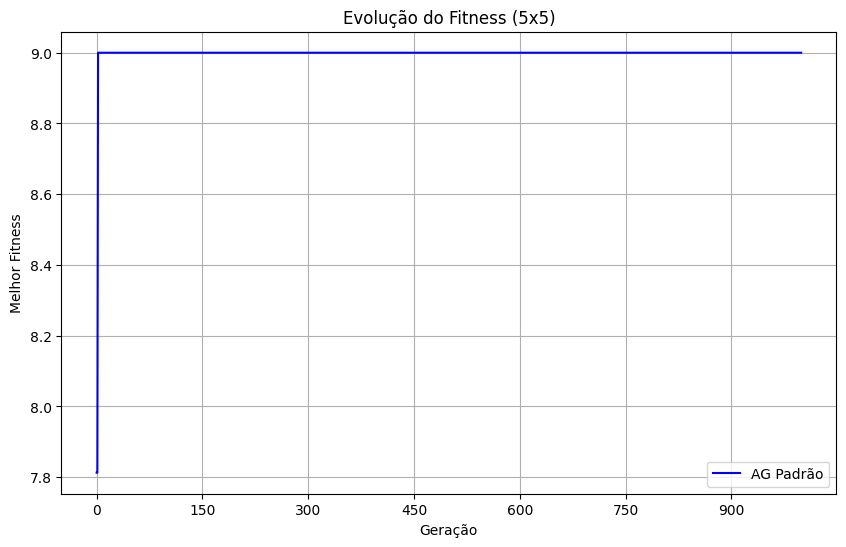

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(history_simple)), 
    history_simple, 
    'b-', 
    label='AG Padrão'
)
plt.title('Evolução do Fitness (5x5)')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)
plt.show()

In [9]:
best_island, history_island = run_ag_island(
    initial_positions,
    min_matrix,
    max_matrix,
    b,
    NUM_ISLAND,
    MIGRATION_INT,
    MIGRATION_SIZE,
)
try:
    A = np.array(best_island._initialize_graph())
    b_np = np.array(b)
    solution = np.linalg.solve(A, b_np)
    print("Solução:")
    for s in solution:
        print(f"== {s}")
except np.linalg.LinAlgError as e:
    print("Erro ao resolver:", e)
print("Fitness Inicial:", best_island.fitness(tester))
print("Melhor indivíduo com estratégia de ilhas:")
print(best_island)
print("Fitness Final:", best_island.fitness(tester))

Solução:
== 2.0
== 0.75
== 1.75
== 0.2777777777777778
== 0.7777777777777778
Fitness Inicial: 9.0
Melhor indivíduo com estratégia de ilhas:
Individual:
[[1, 0, 1, 0, 0], [0, 1, 0, 0, 0], [1, 0, 1, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 1, 1]]
Fitness Final: 9.0


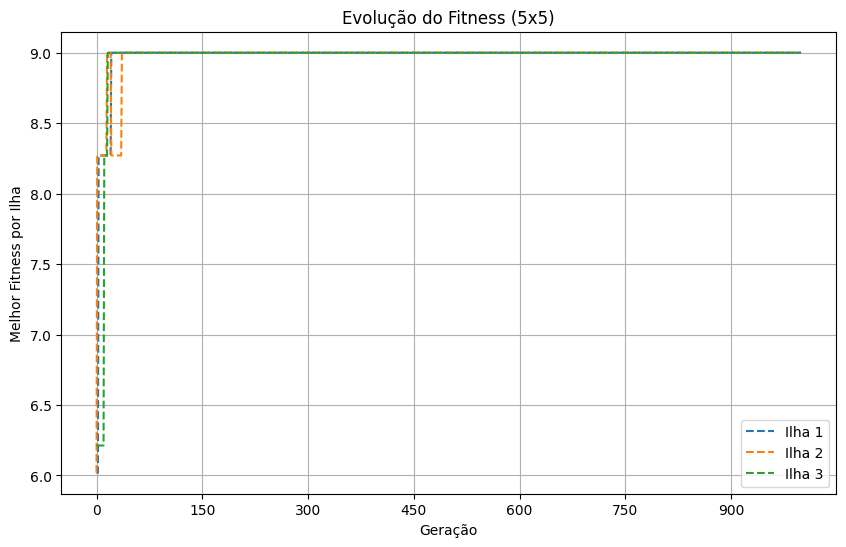

In [10]:
plt.figure(figsize=(10, 6))
for idx, history in enumerate(history_island):
    plt.plot(
        range(len(history)),
        history,
        linestyle='--',
        label=f'Ilha {idx + 1}'
    )
plt.title('Evolução do Fitness (5x5)')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness por Ilha')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)
plt.show()

# 20x20

In [11]:
initial_positions = [
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
]
min_matrix = [
    [100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100]
]
max_matrix = [
    [100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100]
]
b = [
    100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
    100, 100, 100, 100, 100, 100, 100, 100, 100, 100
]

print("Inicial:", Individual(initial_positions, min_matrix, max_matrix, b))

Inicial: Individual:
[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

In [12]:
tester = [
    [100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100, 80],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 100]
]

In [13]:
try:
    A = np.array(tester)
    b_np = np.array(b)
    solution = np.linalg.solve(A, b_np)
    print("Solução:")
    for s in solution:
        print(f"== {s}")
except np.linalg.LinAlgError as e:
    print("Erro ao resolver:", e)

ind_initial = Individual(initial_positions, min_matrix, max_matrix, b)
print("Fitness inicial:", ind_initial.fitness(tester))

best, history_simple = run_ag(initial_positions, min_matrix, max_matrix, b)
print("Melhor indivíduo encontrado:", best)
print("Fitness Final:", best.fitness(tester))

Solução:
== 15.414860933081124
== -18.018576166351405
== 8.358359274858135
== 8.820627072778738
== -18.134143115831556
== 15.097051822010707
== 0.5128283383181724
== -14.488087244908423
== 18.847280717817355
== -7.821013652363265
== -7.821013652363274
== 18.84728071781736
== -14.488087244908424
== 0.5128283383181724
== 15.09705182201071
== -18.13414311583156
== 8.820627072778743
== 8.358359274858131
== -18.018576166351405
== 15.414860933081124
Fitness inicial: 0.7967313088543486
Melhor indivíduo encontrado: Individual:
[[1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0], [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1], [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0], [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 

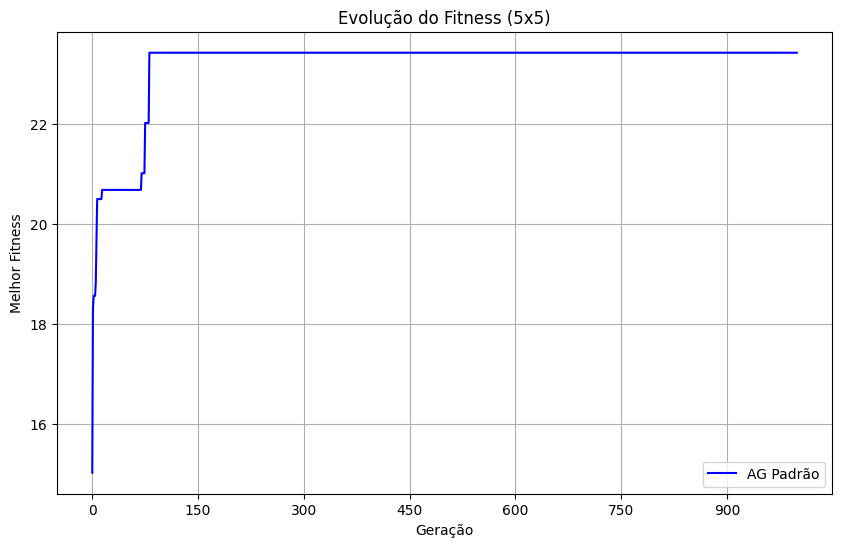

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(history_simple)), 
    history_simple, 
    'b-', 
    label='AG Padrão'
)
plt.title('Evolução do Fitness (20x20)')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)
plt.show()

In [15]:
best_island, history_island = run_ag_island(
    initial_positions,
    min_matrix,
    max_matrix,
    b,
    NUM_ISLAND,
    MIGRATION_INT,
    MIGRATION_SIZE,
)
try:
    A = np.array(best_island._initialize_graph())
    b_np = np.array(b)
    solution = np.linalg.solve(A, b_np)
    print("Solução:")
    for s in solution:
        print(f"== {s}")
except np.linalg.LinAlgError as e:
    print("Erro ao resolver:", e)
print("Fitness Inicial:", best_island.fitness(tester))
print("Melhor indivíduo com estratégia de ilhas:")
print(best_island)
print("Fitness Final:", best_island.fitness(tester))

Solução:
== 0.6901774123755954
== 0.3872782345305059
== 0.07572479446127253
== 0.7680657723929034
== 0.21419299004759837
== 0.21419299004759865
== 0.7680657723929033
== 0.07572479446127209
== 0.3872782345305065
== 0.6901774123755947
== 0.690177412375595
== 0.38727823453050614
== 0.07572479446127237
== 0.7680657723929034
== 0.21419299004759845
== 0.21419299004759842
== 0.7680657723929035
== 0.07572479446127225
== 0.3872782345305062
== 0.690177412375595
Fitness Inicial: 23.41438703140831
Melhor indivíduo com estratégia de ilhas:
Individual:
[[1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1], [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1], [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1], [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1], [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 1, 1

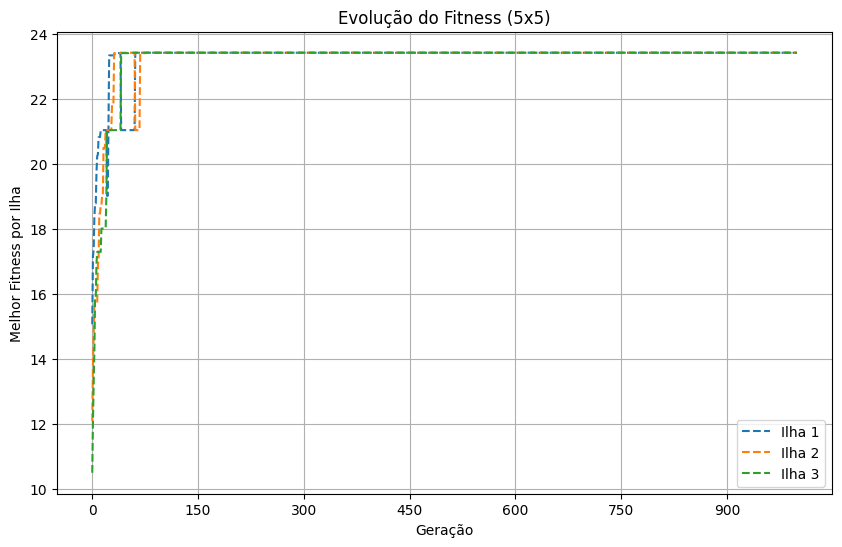

In [16]:
plt.figure(figsize=(10, 6))
for idx, history in enumerate(history_island):
    plt.plot(
        range(len(history)),
        history,
        linestyle='--',
        label=f'Ilha {idx + 1}'
    )
plt.title('Evolução do Fitness (20x20)')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness por Ilha')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)
plt.show()